<a href="https://www.goes-r.gov/">
<img src='./GOES-R_logo_small.png' style="height:150px" align=right alt="GOES16 Logo">
</a>

# GOES-16: True Color Recipe
__Brian Blaylock__   
__July 5, 2018__  
| brian.blaylock@utah.edu | [website](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html) |  


This Python 3 notebook shows how to make a true color image from the GOES-16 Advanced Baseline Imager (ABI) level 2 data. We will plot the image with `matplotlib` and `Basemap`. The image can be disaplayed on any map projection after applying a transformation using `pyproj`. The methods shown here are stitched together from the following useful information I found online:
- [ABI Bands Quick Information Guides](https://www.goes-r.gov/education/ABI-bands-quick-info.html)
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](https://proj4.org/operations/projections/geos.html?highlight=geostationary)
- [Pyproj documentation](http://jswhit.github.io/pyproj/pyproj.Proj-class.html)

True color images are an RGB composite of the following three channels:

|          | Wavelength   | Channel | Description |
|----------|:------------:|:-------:|:-----------:|
| **Red**  | 0.64 &#181;m |    2    | Red Visible |
| **Green**| 0.86 &#181;m |    3    | Veggie Near-IR|
| **Blue** | 0.47 &#181;m |    1    | Blue Visible|


---

## Download a GOES-16 ABI data file
For this demo, you will need GOES-16 ABI level 2 data. You can get GOES-16 files from NOAA's GOES archive on [Amazon S3](https://aws.amazon.com/public-datasets/goes/). I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0) to easily download files from the Amazon archive. For scripted downloads, you should use `rclone` or `AWS CLI`.

This example uses the **level 2 _multiband_ formatted file for the _CONUS_ domain** ([ABI-L2-MCMIPC](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0)). The multiband file is easiest to work with becuase it contains all 16 channels on the same 2 km grid. However, some channels have higher resolution. Plotting the full resolution images will take some additional work, not described here. Specifically, you will have to download three separate files, one for each channel, and subsample the red channel to a 1 km.

I previously downloaded the following file from Amazon Web Services

    OR_ABI-L2-MCMIPC-M3_G16_s20181781922189_e20181781924562_c20181781925075.nc

>OR     - Indicates the system is operational  
 ABI    - Instrument type  
 L2     - Level 2 Data  
 MCMIP  - Multichannel Cloud and Moisture Imagery products  
 c      - CONUS file (created every 5 minutes).  
 M3     - Scan mode  
 G16    - GOES-16  
 s##### - Scan start: 4 digit year, 3 digit day of year (julian day), hour, minute, second, tenth second  
 e##### - Scan end
 c##### - File Creation  
 .nc    - NetCDF file extension  

More information about GOES-16 files can be found on [Amazon AWS](https://docs.opendata.aws/noaa-goes16/cics-readme.html).

## First, import the libraries we will use

In [1]:
%matplotlib inline

import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Open the GOES-16 NetCDF File
Using xarray, I assign the file to the variable C for 'CONUS'

In [2]:
FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20181781922189_e20181781924562_c20181781925075.nc'

C = xarray.open_dataset(FILE)

## Date and Time Information
Each file represents the data collected during one scan sequence for the domain. There are several different time stamps in this file, which are also found in the file's name.

In [3]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)

Scan Start    : 2018-06-27 19:22:18.900000
Scan midpoint : 2018-06-27 19:23:37.600000
Scan End      : 2018-06-27 19:24:56.200000
File Created  : 2018-06-27 19:25:07.500000


## True Color Recipe
Color images are a Red-Green-Blue (RGB) composite of three different channels. We will assign the following channels as our RGB values:


|               | **RED**      | **GREEN**      | **BLUE**     |
|---------------|:------------:|:--------------:|:------------:|
| **Name**      | Red Visibile | Near-IR Veggie | Blue Visible |
| **Wavelength**| 0.64 &#181;m | 0.86 &#181;m   | 0.47 &#181;m |
| **Channel**   |      2       |       3        |      1       |
| **Units**     | reflectance range [0-1] | reflectance range [0-1]  | reflectance range [0-1] |

The GREEN "veggie" channel on GOES-16 does not measure visible green light. Instead, it measures a near-infrared band sensitive to chlorophyll. We could use that channel in place of green, but it would make the green in our image appear too vibrant. Instead, we will _tone-down_ the green channel by interpolating the value to simulate a _natural green_ color.

\begin{equation}
TrueGreen = (0.48358168*RED) + (0.45706946*BLUE) + (0.06038137*GREEN)
\end{equation}

The multiband formated file we loaded is convenient becuase all the GOES channels are in the same NetCDF file.

In [4]:
# Confirm that each band is the wavelength we are interested in
for band in [2, 3, 1]:
    print("%s is %.2f %s" % (C['band_wavelength_C%02d' % band].long_name,
                             C['band_wavelength_C%02d' % band][0],
                             C['band_wavelength_C%02d' % band].units))

ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.87 um
ABI band 1 central wavelength is 0.47 um


In [5]:
# Load the three channels into appripriate R, G, and B variables
R = C['CMI_C02'].data
G = C['CMI_C03'].data
B = C['CMI_C01'].data

In [6]:
# RGB values must be between 0 and 1.
R = np.maximum(R, 0)
G = np.maximum(G, 0)
B = np.maximum(B, 0)

R = np.minimum(R, 1)
G = np.minimum(G, 1)
B = np.minimum(B, 1)

In [7]:
# Apply a gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

In [8]:
# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

## Simple Image
Use `plt.imshow` to get a quick look at the channels and RGB composite we created.

First, plot each channel individually. The deeper the color means the satellite is observing more light in that channel. Clouds appear white becuase they reflect lots of red, green, and blue light. You will also notice that the land reflects a lot of "green" in the veggie channel.

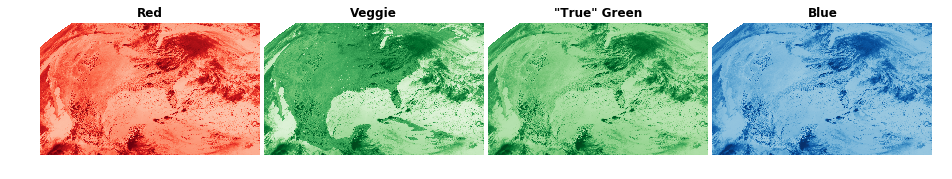

In [9]:
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16,3))

ax1.imshow(R, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='semibold')
ax1.axis('off');

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Veggie', fontweight='semibold')
ax2.axis('off');

ax3.imshow(G_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='semibold')
ax3.axis('off');

ax4.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='semibold')
ax4.axis('off');

plt.subplots_adjust(wspace=.02)

The addition of the three channels results in a color image.

In [10]:
# The RGB array with the raw veggie band
RGB_veggie = np.dstack([R, G, B])

# The RGB array for the true color image
RGB = np.dstack([R, G_true, B])

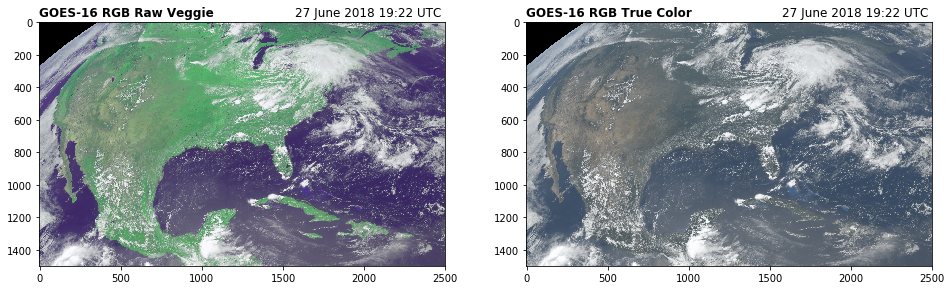

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# The RGB using the raw veggie band
ax1.imshow(RGB_veggie)
ax1.set_title('GOES-16 RGB Raw Veggie', fontweight='semibold', loc='left', fontsize=12);
ax1.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

# The RGB with the veggie band interpolated to appear more natural
ax2.imshow(RGB)
ax2.set_title('GOES-16 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
ax2.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

## Plot with `Basemap`: Geostationay Projection
The problem with the above image is that it is not georeferenced. You can see the land and oceans, but we do have enough information to draw state and country boundaries. From the GOES-16 file, we can extract all the metadata needed to understand the map projection. We will use this data to plot the image on a `Basemap`. The image is in a [geostationary projection](https://proj4.org/operations/projections/geos.html?highlight=geostationary).

In [12]:
C['goes_imager_projection']

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    t        datetime64[ns] 2018-06-27T19:23:37.629063040
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

In [13]:
# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

The geostationary projection is the easiest way to plot the image on a map. Essentially, we are stretching the image across a map with the same projection and dimensions as the data.

In [14]:
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=5000,
            llcrnrx=x.min(),llcrnry=y.min(),
            urcrnrx=x.max(),urcrnry=y.max())

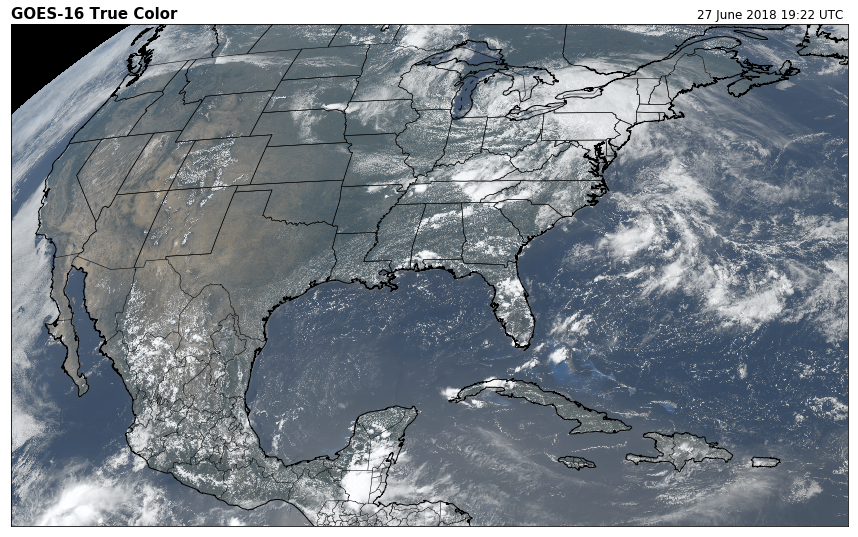

In [15]:
plt.figure(1, figsize=[15, 12])
m.imshow(np.flipud(RGB)) # Since "images" are upside down, we flip the RGB up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('GOES-16 True Color', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

## Other projections

To apply a transformation of the image on other projections, we need to georeference each pixel. We will use the metadata in the file and `pyproj` to calculate the latitude and longitude of each pixel so we can project the image onto other map projections. This is done by using an inverse transformation of the map projection object, `p`, of the map coordinates given by X and Y. The image will then need to be plotted with `pcolormesh` becuase imshow can only plot rectangular images. Plotting an RGB with `pcolormesh` is not trivial, but the steps are described in this section.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [16]:
# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [17]:
# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

In the above image, you see a black area in the upper left corner. Since these pixels displaying outer space do not have coordinates on the globe, pyproj.Proj assigns these points a value 1e30. We will assign the latitude and longitude of these pixels as an arbitrary location in the Gulf of Alaska, a point that will not overlap the other data points. We do this becuase `pcolormesh` needs to know the latitude and longitude of every pixel and the x and y value cannot contain nans or masked values. Thus `pcolormesh` will strech the black pixels in the corner of our GOES-16 image to converge on the coordinates 57 North and 152 West. The image will not display correctly without this step.

In [18]:
# Assign the pixels showing space as a single point in the Gulf of Alaska
lats[np.isnan(R)] = 57
lons[np.isnan(R)] = -152

 ## Plot with `Basemap`: Lambert Conformal Projection
 I am going to project the GOES-16 data on the Lambert Conformal Projection.

In [19]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=3000*3000, height=2500*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

We can't simply plot the reprojected image with `imshow` because the pixels are spaced irregularly. We have to use `pcolormesh`, which is not a trivial task. We need to create a flattened array of a color tuple for each pixel. Details on doing this are on stackoverflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [20]:
# Create a color tuple for pcolormesh

# Don't use the last column of the RGB array or else the image will be scrambled!
# This is the stange nature of pcolormesh.
rgb = RGB[:,:-1,:]

# Flatten the array, becuase that's what pcolormesh wants.
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)

# Adding an alpha channel will plot faster, according to stackoverflow. Not sure why.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

Now we can plot the GOES data on the new projection using pcolormesh

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


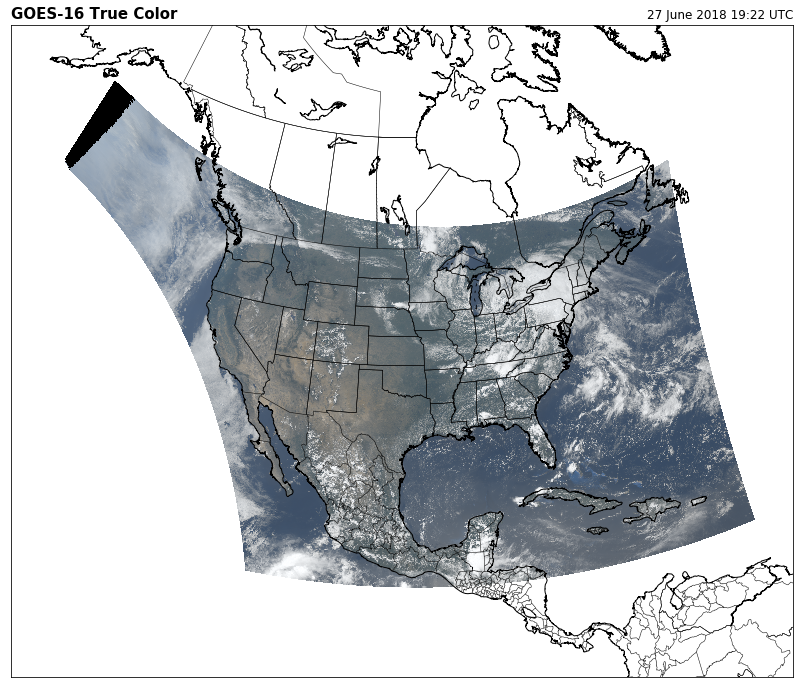

In [21]:
plt.figure(figsize=[15, 12])

# We need an array the shape of the data, so use R. The color of each pixel will be set by color=colorTuple.
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # Without this line the RGB colorTuple is ignored.

mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 True Color', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');

 ## Plot with `Basemap`: Cylindrical Projection
 It is often useful to zoom on a specific location. We next plot the true color image zoomed over Utah.

In [22]:
# Location of Utah
l = {'latitude': 39.75,
     'longitude': -111.5}

# Draw zoomed map
mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-3.25, llcrnrlat=l['latitude']-3.25,\
             urcrnrlon=l['longitude']+3.25, urcrnrlat=l['latitude']+3.25,)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


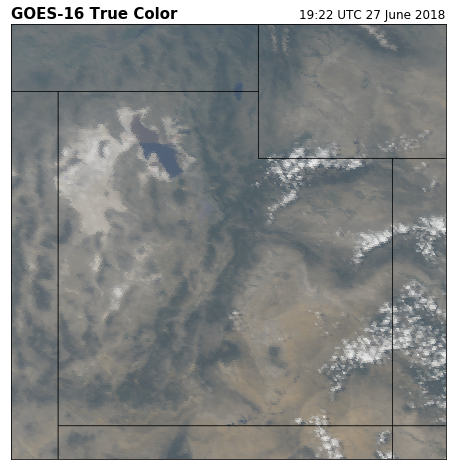

In [23]:
# Now we can plot the GOES data on a zoomed in map centered over Utah.
plt.figure(figsize=[8, 8])

newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)

mZ.drawcoastlines()
mZ.drawcountries()
mZ.drawstates()

plt.title('GOES-16 True Color', loc='left', fontweight='semibold', fontsize=15);
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

---

## Overlay Nighttime IR when dark
At nighttime, the visible wavlengths cannot measure anything. The entire domain is black. But there is information from other channels we can use to see where the clouds are at night. To view clouds in portions of the domain experiencing nighttime, we will overlay the clean infrared (IR) channel over the true color image.

First, open a file where the scan shows partial night area and create the true color RGB as before.

In [24]:
# A GOES-16 file with half day and half night
FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20181860102222_e20181860104594_c20181860105108.nc'

C = xarray.open_dataset(FILE)

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Load the three channels into appripriate R, G, and B
R = C['CMI_C02'].data
G = C['CMI_C03'].data
B = C['CMI_C01'].data

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
G = np.maximum(G, 0)
B = np.maximum(B, 0)

R = np.minimum(R, 1)
G = np.minimum(G, 1)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

### _**Load the Clear IR  10.3 &#181;m channel (Band 13)**_  
Clean IR has units of Kelvin, so we need to normalize the temperature array between a range of values.

In [25]:
C['CMI_C13']

<xarray.DataArray 'CMI_C13' (y: 1500, x: 2500)>
[3750000 values with dtype=float32]
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.128212 0.128156 0.12810001 0.12804401 0.12798801 ...
  * x        (x) float32 -0.101332 -0.101276 -0.101220004 -0.101164 ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI Cloud and Moisture Imagery brightness tempera...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF_C13

Notice that the units of the clean IR channel is brightness temperature, NOT reflectance. We will apply some bounds and a normalization to get the data becuase we need it to have a value between 0 and 1.

In [26]:
cleanIR = C['CMI_C13'].data

# Apply range limits for clean IR channel
cleanIR = np.maximum(cleanIR, 90)
cleanIR = np.minimum(cleanIR, 313)

# Normalize the channel between a range
cleanIR = (cleanIR-90)/(313-90)

# Invert colors
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright
cleanIR = cleanIR/1.5

## Show the true color and clean IR images
We want to overlay these so the clean IR will fill in the black area on the True Color image

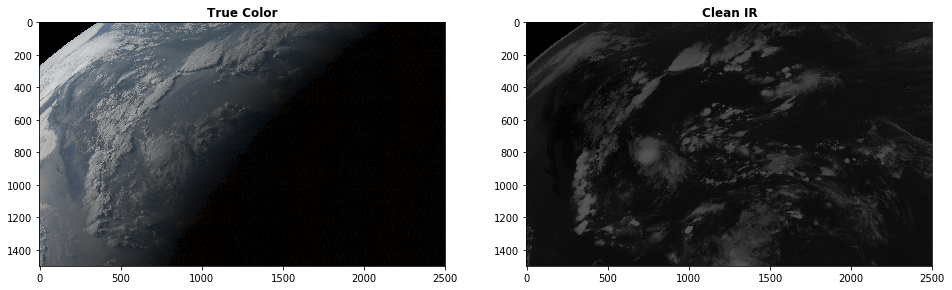

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.imshow(np.dstack([R, G_true, B]))
ax2.imshow(np.dstack([cleanIR, cleanIR, cleanIR]))
ax1.set_title('True Color', fontweight='semibold');
ax2.set_title('Clean IR', fontweight='semibold');

To fill in the dark area on the true color image, we will set each RGB channel to equal the maximum value between the visible channels and the IR channels. This may require some interpretation beucase if the Clean IR has bright clouds in the daylight, they will replace the color values in the true color image. Still, it makes a nice plot and allows you to see clouds when it is nightime.

In [28]:
RGB_IR = np.dstack([np.maximum(R, cleanIR), np.maximum(G_true, cleanIR), np.maximum(B, cleanIR)])

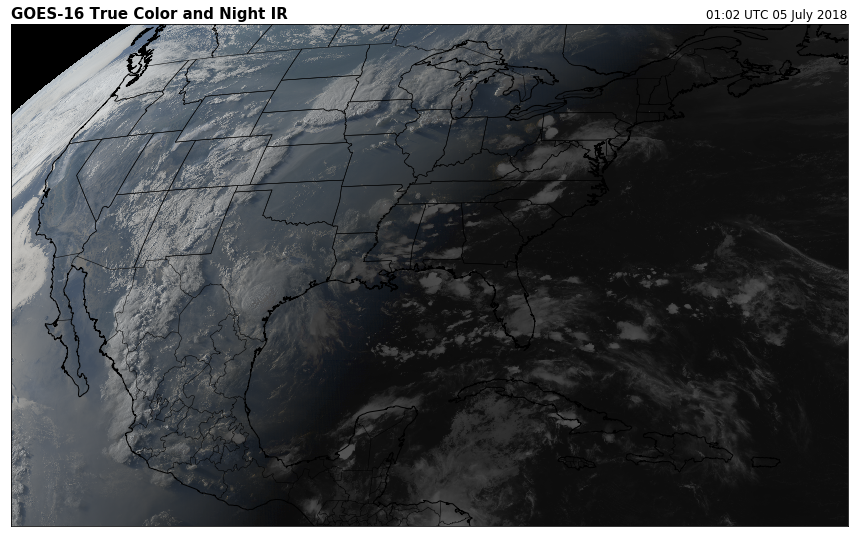

In [29]:
plt.figure(figsize=[15, 12])
m.imshow(np.flipud(RGB_IR))
m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('GOES-16 True Color and Night IR', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

---
# Adjust Image Contrast
I think the color looks a little dull. We can make the colors pop out by adjusting the contrast. Adjusting image contrast is easy to do in Photoshop, and also easy to do in Python.

Note: you should adjust the contrast _before_ you add in the Clean IR channel.

In [30]:
def contrast_correction(color, contrast):
    """
    Modify the contrast of an RGB
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR

# Amount of contrast
contrast_amount = 105

# Apply contrast correction
RGB_contrast = contrast_correction(np.dstack([R, G_true, B]), contrast_amount)

# Add in clean IR
RGB_contrast_IR = np.dstack([np.maximum(RGB_contrast[:,:,0], cleanIR), np.maximum(RGB_contrast[:,:,1], cleanIR), np.maximum(RGB_contrast[:,:,2], cleanIR)])

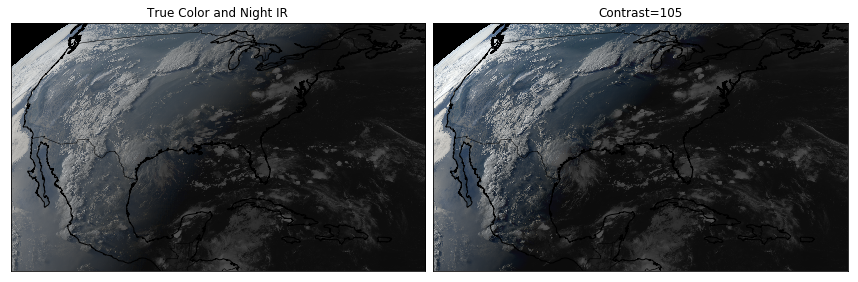

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,12))
plt.sca(ax1)
m.imshow(np.flipud(RGB_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('True Color and Night IR')

plt.sca(ax2)
m.imshow(np.flipud(RGB_contrast_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('Contrast=%s' % contrast_amount)

plt.subplots_adjust(wspace=.02)

----

# Can we make plots for a Mesoscale scan?
Yes. Yes we can.

In [32]:
# M1 is for the Mesoscale1 NetCDF file
FILE = 'OR_ABI-L2-MCMIPM1-M3_G16_s20172531800245_e20172531800302_c20172531800373.nc'
M1 = xarray.open_dataset(FILE)

# Load the RGB arrays
R = M1['CMI_C02'][:].data
G = M1['CMI_C03'][:].data
B = M1['CMI_C01'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(M1.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Satellite height
sat_h = M1['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = M1['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = M1['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
x = M1['x'][:] * sat_h
y = M1['y'][:] * sat_h

Text(0,1,'Mesoscale Section 1')

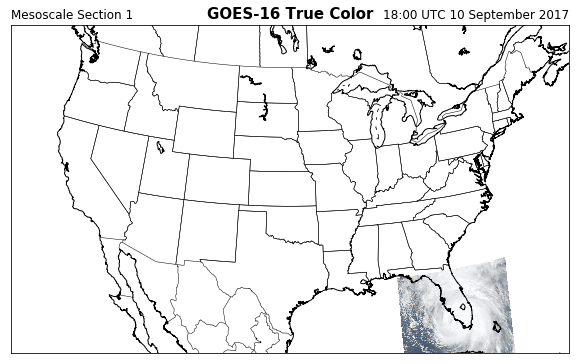

In [33]:
# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=1500, \
            width=1800*3000, height=1060*3000, \
            lat_1=38.5, lat_2=38.5, \
            lat_0=38.5, lon_0=-97.5)

xH, yH = mH(lons, lats)

# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] 
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[10, 8])

newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None)

mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right')
plt.title('Mesoscale Section 1', loc='left')

In [34]:
# The geostationary projection
mM1 = Basemap(projection='geos', lon_0=sat_lon, resolution='i',
              llcrnrx=XX.min(),llcrnry=YY.min(),
              urcrnrx=XX.max(),urcrnry=YY.max())

Text(1,1,'Mesoscale Scan 1\n18:00 UTC 10 September 2017')

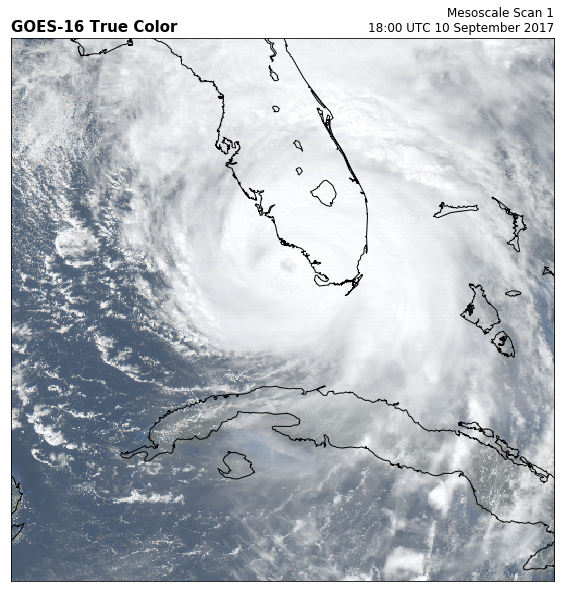

In [35]:
plt.figure(figsize=[10, 10])
mM1.imshow(np.flipud(RGB))
mM1.drawcoastlines()
mM1.drawcountries()
mM1.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15, loc='left')
plt.title('Mesoscale Scan 1\n%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right')

----

# Can we do this for a Full Disk Scan? It's possible...
but data files are so large, plotting anythig is very slow. I don't need to do this, so I wont worry about it.

In [36]:
# F is for Full Disk
FILE = 'OR_ABI-L2-MCMIPF-M3_G16_s20172531745358_e20172531756131_c20172531756202.nc'
F = xarray.open_dataset(FILE)

# Load the RGB arrays
R = F['CMI_C02'][:].data
G = F['CMI_C03'][:].data
B = F['CMI_C01'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

In [37]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(F.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Satellite height
sat_h = F['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = F['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = F['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
x = F['x'][:] * sat_h
y = F['y'][:] * sat_h

##### Geostationary projection is easy

In [38]:
# The geostationary projection
mF = Basemap(projection='geos', lon_0=sat_lon,
             llcrnrx=x.min(),llcrnry=y.min(),
             urcrnrx=x.max(),urcrnry=y.max())

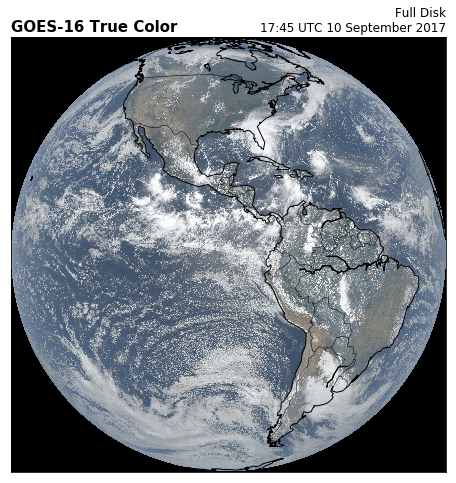

In [39]:
plt.figure(figsize=[10, 8])
mF.imshow(np.flipud(RGB))
mF.drawcoastlines()
mF.drawcountries()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15, loc='left')
plt.title('Full Disk\n%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

I haven't had much luck plotting full disk images on other map projections due to the excessive black space. I haven't needed to do this myself. But if you need to do this, here's a starting point...

In [40]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(x, y)

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
lons, lats = p(XX, YY, inverse=True)

# ...